# <span style="color:black"> LSN-Esercitazione numerica 7</span>

## <span style="color:blue">  Esercizio 07.1-07.2-07.3-07.4</span>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.gridspec as gridspec
import scipy.optimize as opt

Prsento di seguito i risultati delle simulazioni del codice che descrive un sistema canonico di Lennard-Jones attraverso l'algoritmo Monte Carlo per le tre diverse fasi dell'Argon.

Innanzitutto sono andato ad equilibrare il sistema facendo una simulazione di 1000 step con configurazione iniziale data da un reticolo cristallino perfetto FCC: plotto gli andamenti di energia potenziale per particella $E_{pot}^*/N$ e pressione P* in unità di Lennard-Jones per mostrare la riuscita della fase di equilibrazione. Attraverso questa breve simulazione si è anche fissato un passo $delta$ per ogni fase tale che il rapporto di accettazione dell'algoritmo Monte Carlo fosse prossimo al 50%.

Successivamente studio la funzione di autocorellazione (fittata con una funzione esponenziale) per le due grandezze termodinamiche e l'andamento delle incertezze stimate con il metodo del Data-blocking in funzione della grandezza del blocco. Per farlo ho studiato i valori istantanei di una simulazione di $10^5$ step Monte Carlo con configurazione iniziale data da quella conclusiva della fase di equilibrazione. Ho scritto due script Python per la stima dell'autocorrelazione e per lo studio dell'incertezza in funzione del numero di step all'interno del singolo blocco.

Infine descrivo l'energia potenziale per particella e la pressione in funzione dei blocchi e l'andamento della funzione di distribuzione radiale $g(r)$ in funzione della distanza fra due particelle: le grandezze sono presentato in unità di misura del sistema internazionale attraverso opportuni riscalamenti:
$E_{pot}= \epsilon E_{pot}^* \quad \quad       
P=\left(\epsilon/\sigma^3\right)P^*$

Si traccia, inoltre, la funzione $g(r)$ studiata attraverso l'algortimo di Dinamica Molecolare dell'esercitazione 4 dopo aver, anche in questo caso, equilibrato il sistema. La simualzione, in questo caso, è costituita da 100 blocchi di 2000 step.

## Fase liquida

Fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)

In [2]:
Epotl = np.loadtxt('./Liquid/Equi/output.epot.dat', usecols=(0), unpack='true')
presl = np.loadtxt('./Liquid/Equi/output.pres.dat', usecols=(0), unpack='true')

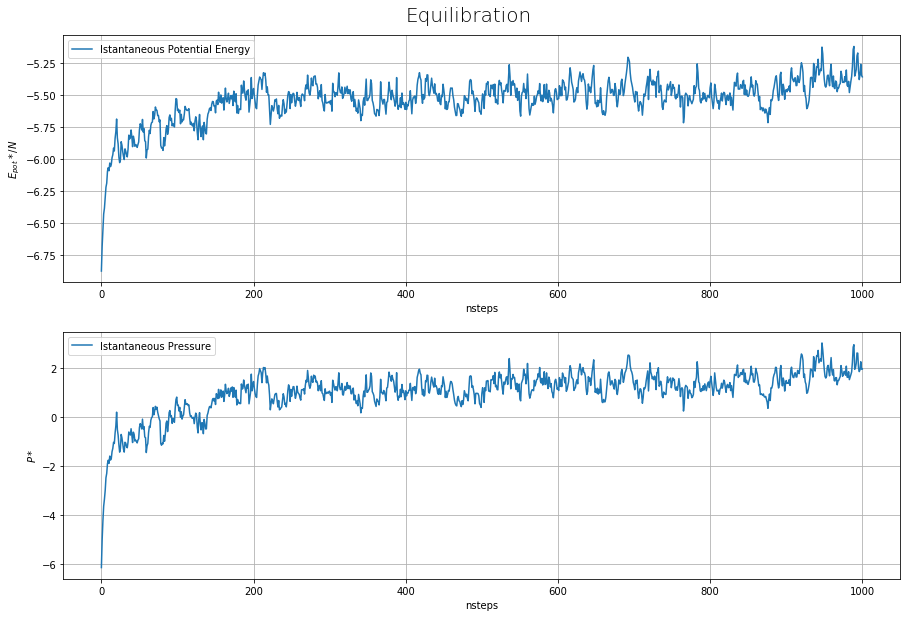

In [3]:
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Equilibration', y='0.92', size='20', weight='20')
gs = gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
plt.plot(Epotl, label="Istantaneous Potential Energy" )
plt.xlabel("nsteps")
plt.ylabel("$E_{pot}*/N$")
plt.grid(True)
plt.legend()

ax2 = fig.add_subplot(gs[1, :])
plt.plot(presl, label="Istantaneous Pressure" )
plt.xlabel("nsteps")
plt.ylabel("$P*$")
plt.grid(True)
plt.legend()
plt.show()

Il sistema è già equilibrato dopo 200 step.

In [4]:
def autocorr(x):
    t_max=len(x);
    var=np.var(x);
    t_cut=500;
    prod=np.zeros(t_cut);
    x_t=np.zeros(t_cut);
    x_dt=np.zeros(t_cut);
    autoc=np.zeros(t_cut);
    for t in range(t_cut):
        sum_prod=0;
        sum_x_t=0;
        sum_x_dt=0;
        for i in range(t_max-t_cut):
            sum_prod+=x[i]*x[i+t];
            sum_x_t+=x[i];
            sum_x_dt+=x[i+t];
        prod[t]=sum_prod/(t_max-t_cut);
        x_t[t]=sum_x_t/(t_max-t_cut);
        x_dt[t]=sum_x_dt/(t_max-t_cut);
        autoc[t]=(prod[t]-x_t[t]*x_dt[t])/var;
    return autoc

In [5]:
def f(x, tc, A):
    return A*np.exp(-x/tc)

In [6]:
Epot = np.loadtxt('./Liquid/output.epot.dat', usecols=(0), unpack='true')
pres = np.loadtxt('./Liquid/output.pres.dat', usecols=(0), unpack='true')

autoE=autocorr(Epot)
autoP=autocorr(pres)

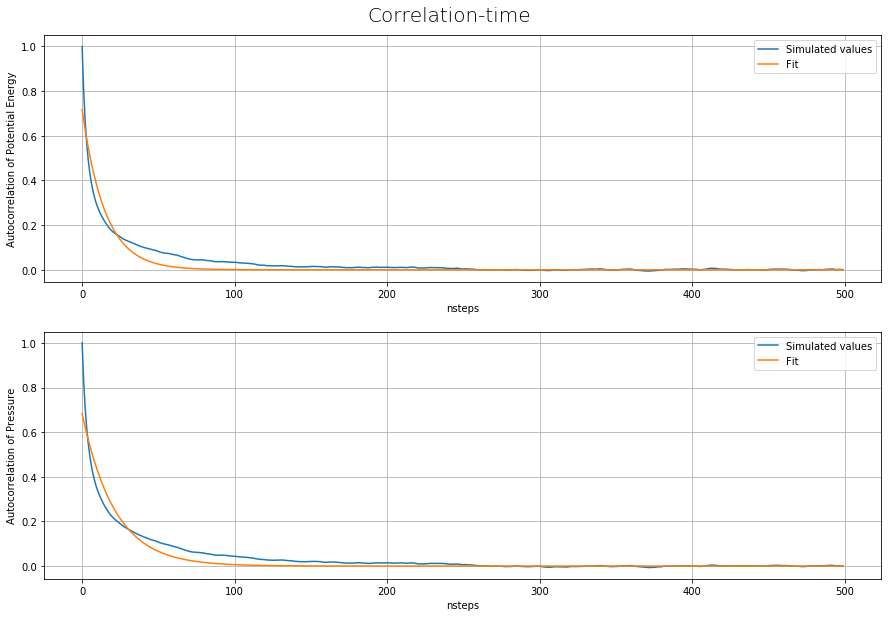

In [8]:
x=np.arange(0, 500, 1)
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Correlation-time', y='0.92', size='20', weight='20')
gs = gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
p_opt, p_cov = opt.curve_fit(f, x, autoE)
y_fit = f(x,p_opt[0], p_opt[1])
plt.plot(x, autoE, label="Simulated values")
plt.plot(x,y_fit, label="Fit") # plotting fitted function
plt.xlabel("nsteps")
plt.ylabel("Autocorrelation of Potential Energy")
plt.grid()
plt.legend()


ax2 = fig.add_subplot(gs[1, :])
p_opt, p_cov = opt.curve_fit(f, x, autoP)
y_fit = f(x,p_opt[0], p_opt[1])
plt.plot(x, autoP, label="Simulated values")
plt.plot(x,y_fit, label="Fit") # plotting fitted function
plt.xlabel("nsteps")
plt.ylabel("Autocorrelation of Pressure")
plt.grid()
plt.legend()

plt.show()



La funzione di correlazione studiata assume valori in input fra 0 e 500. Si è fitatta tale funzione per i valori istantanei di energia potenziale e pressione ricavando un valore di tempo di correlazione pari a 25 per la pressione e 18 per l'energia. Il fatto che il valore del tempo di correlazione sia molto minore del valore massimo imposto per l'autocorrelazione giustifica la scelta fatta.

In [9]:
def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return math.sqrt((AV2[n] - AV[n]**2)/n)

def Statist_Unc(E):
    M=len(E)
    Lmin=100
    Lmax=5000
    step=100
    tot=int((Lmax-Lmin)/step)

    size = np.zeros(tot)
    sigma = np.zeros(tot)
    cont=0

    for L in range (Lmin, Lmax, step):
        N=int(M/L)  
        ave = np.zeros(N)
        av2 = np.zeros(N)
        sum_prog = np.zeros(N)
        su2_prog = np.zeros(N)
        err_prog = np.zeros(N)

        for i in range(N):
            sum = 0
            for j in range(L):
                k = j+i*L
                sum += E[k]
            ave[i] = sum/L       # r_i 
            av2[i] = (ave[i])**2 # (r_i)^2 

        for i in range(N):
            for j in range(i+1):
                sum_prog[i] += ave[j] # SUM_{j=0,i} r_j
                su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
            sum_prog[i]/=(i+1) # Cumulative average
            su2_prog[i]/=(i+1) # Cumulative square average
            err_prog[i] = error(sum_prog,su2_prog,i) # Statistical uncertainty
        size[cont]=L
        sigma[cont]=err_prog[N-1]
        cont+=1
        
    return size, sigma


In [10]:
sizeE, sigmaE=Statist_Unc(Epot)
sizeP, sigmaP=Statist_Unc(pres)

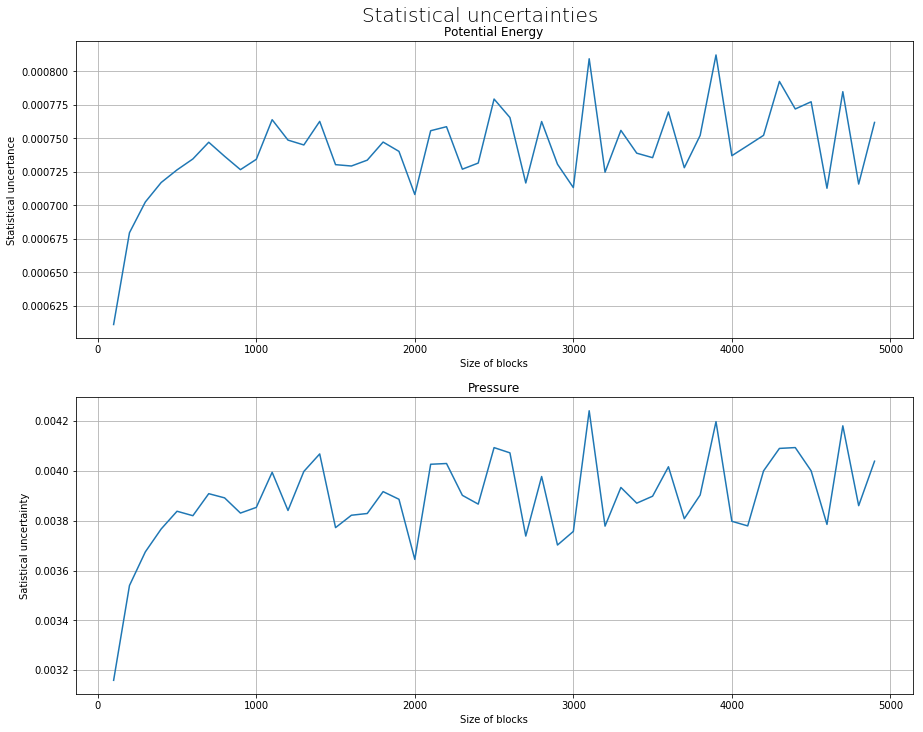

In [11]:
fig = plt.figure(figsize=(15, 12))
fig.suptitle('Statistical uncertainties', y='0.92', size='20', weight='20')
gs = gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
plt.plot(sizeE, sigmaE)
plt.xlabel("Size of blocks")
plt.ylabel("Statistical uncertance")
plt.grid()
plt.title("Potential Energy")

ax2 = fig.add_subplot(gs[1, :])
plt.plot(sizeP,sigmaP)
plt.xlabel("Size of blocks")
plt.ylabel("Satistical uncertainty")
plt.grid()
plt.title("Pressure")

plt.show()

Le incertezze studiate in funzione della dimensione del blocco mostrano come esse siano sottostimate per una dimensioni troppo ridotte; incrementando il numero degli elementi nel blocco L=M/N, ad M fissato, le incertezze tendono all'errore statistico vero legato all'utilizzo delle catene di Markov. Quando questa soglia è raggiunta aumentando ulteriormente L non si va a modificare l'incertezza.

Il valore del tempo di correlazione stimato, invece, è minore del centinaio: si è scelto, quindi, di studiare 500 blocchi ognuno costituito da 1000 step Monte Carlo: in questa sitauzione sicuramente ogni blocco presenta dati scorrelati e incertezze non sottostimate (la stessa scelta è stata fatta anche pre le altre due fasi studiate).

In [12]:
block, epot, sigmaepot = np.loadtxt('./Liquid/output.epot.0', usecols=(0,2,3), unpack='true')
block, press, sigmapress= np.loadtxt('./Liquid/output.pres.0', usecols=(0,2,3), unpack='true')
r, g, sigmag= np.loadtxt('./Liquid/output.gave.0', usecols=(0,1,2), unpack='true')

eps_kb=120 #Argon
sigma=0.34e-9

k=1.380649e-23
eps=eps_kb*k
#SI

epot=epot*eps
sigmaepot=sigmaepot*eps

press=press*eps/(sigma*sigma*sigma)
r=r*sigma

In [13]:
r4, g4, sigmag4= np.loadtxt('./MolDyn_NVE/Liquid/output.gave.0', usecols=(0,1,2), unpack='true')
r4=r4*sigma

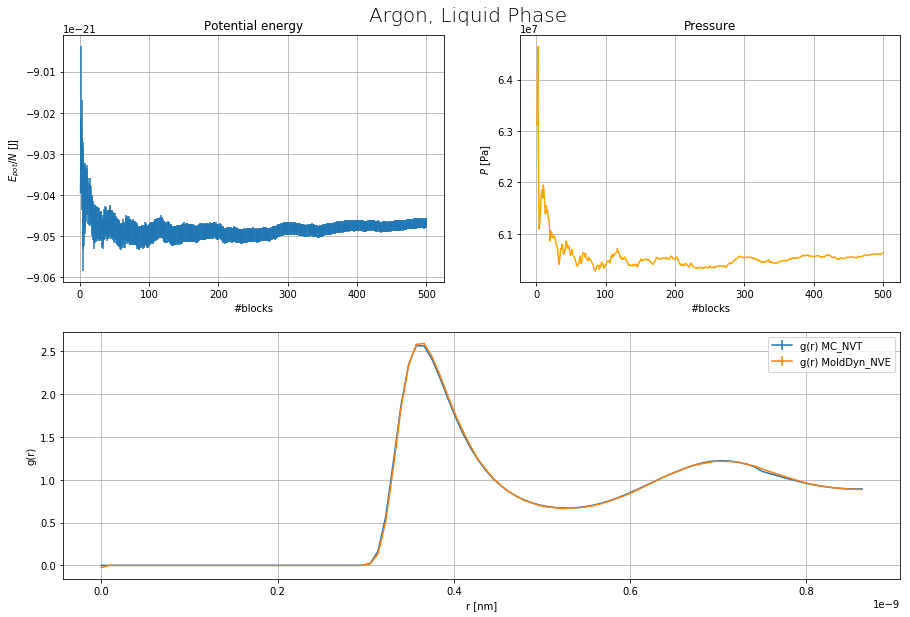

In [15]:
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Argon, Liquid Phase', y='0.92', size='20', weight='20')
gs = gridspec.GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
plt.errorbar(block,epot,yerr=sigmaepot)
plt.xlabel('#blocks')
plt.ylabel('$E_{pot}/N$ [J]')
plt.title ("Potential energy")
plt.grid(True)

ax2 = fig.add_subplot(gs[0, 1])
plt.errorbar(block,press,yerr=sigmapress, color="orange")
plt.xlabel('#blocks')
plt.ylabel('$P$ [Pa]')
plt.title ("Pressure")
plt.grid(True)


ax5 = fig.add_subplot(gs[1, :])
plt.errorbar(r,g,yerr=sigmag, label="g(r) MC_NVT")
plt.errorbar(r4,g4,yerr=sigmag4, label="g(r) MoldDyn_NVE")
plt.xlabel('r [nm]')
plt.ylabel('g(r)')
ax5.legend()
plt.grid(True)

plt.show()

La funzioni di distribuzione radiale calcolate coi due diversi algoritmi quasi totalmente sovrapposte.  Le barre di errore sono plottate ma molto ridotte.

## Fase solida

Fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)

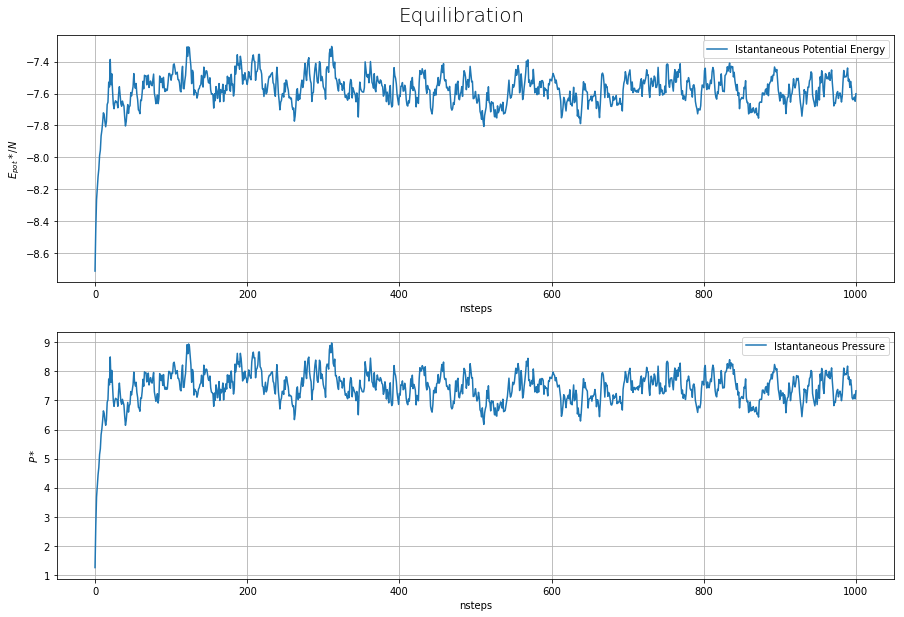

In [10]:
Epot = np.loadtxt('./Solid/Equi/output.epot.dat', usecols=(0), unpack='true')
pres = np.loadtxt('./Solid/Equi/output.pres.dat', usecols=(0), unpack='true')

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Equilibration', y='0.92', size='20', weight='20')
gs = gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
plt.plot(Epot, label="Istantaneous Potential Energy" )
plt.xlabel("nsteps")
plt.ylabel("$E_{pot}*/N$")
plt.grid(True)
plt.legend()

ax2 = fig.add_subplot(gs[1, :])
plt.plot(pres, label="Istantaneous Pressure" )
plt.xlabel("nsteps")
plt.ylabel("$P*$")
plt.grid(True)
plt.legend()
plt.show()

Il sistema si equilibra in pochissimi passi, meno di 100.

In [10]:
Epot = np.loadtxt('./Solid/output.epot.dat', usecols=(0), unpack='true')
pres = np.loadtxt('./Solid/output.pres.dat', usecols=(0), unpack='true')

autoE=autocorr(Epot)
autoP=autocorr(pres)

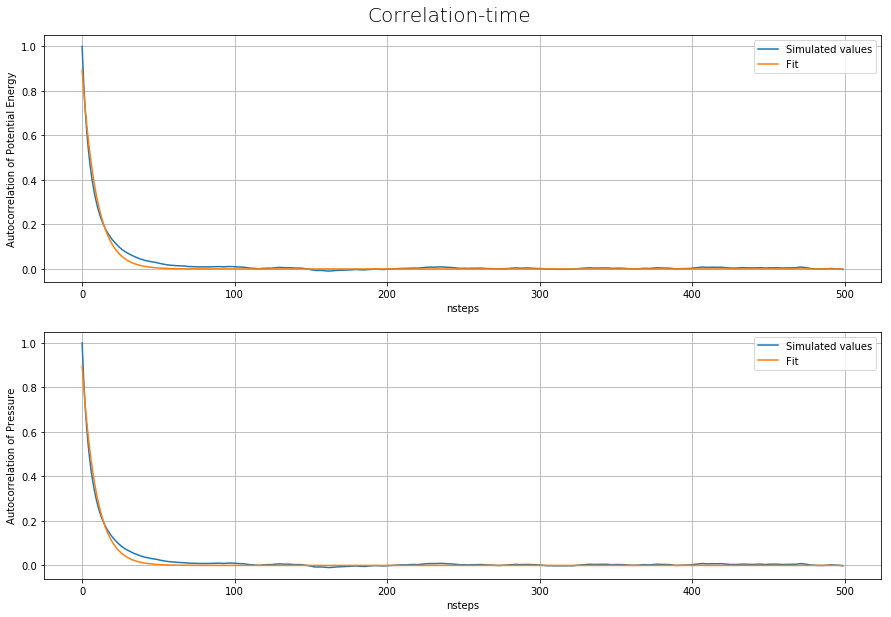

In [11]:
x=np.arange(0, 500, 1)
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Correlation-time', y='0.92', size='20', weight='20')
gs = gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
p_opt, p_cov = opt.curve_fit(f, x, autoE)
y_fit = f(x,p_opt[0], p_opt[1])
plt.plot(x, autoE, label="Simulated values")
plt.plot(x,y_fit, label="Fit") # plotting fitted function
plt.xlabel("nsteps")
plt.ylabel("Autocorrelation of Potential Energy")
plt.grid()
plt.legend()


ax2 = fig.add_subplot(gs[1, :])
p_opt, p_cov = opt.curve_fit(f, x, autoP)
y_fit = f(x,p_opt[0], p_opt[1])
plt.plot(x, autoP, label="Simulated values")
plt.plot(x,y_fit, label="Fit") # plotting fitted function
plt.xlabel("nsteps")
plt.ylabel("Autocorrelation of Pressure")
plt.grid()
plt.legend()

plt.show()



In [12]:
sizeE, sigmaE=Statist_Unc(Epot)
sizeP, sigmaP=Statist_Unc(pres)

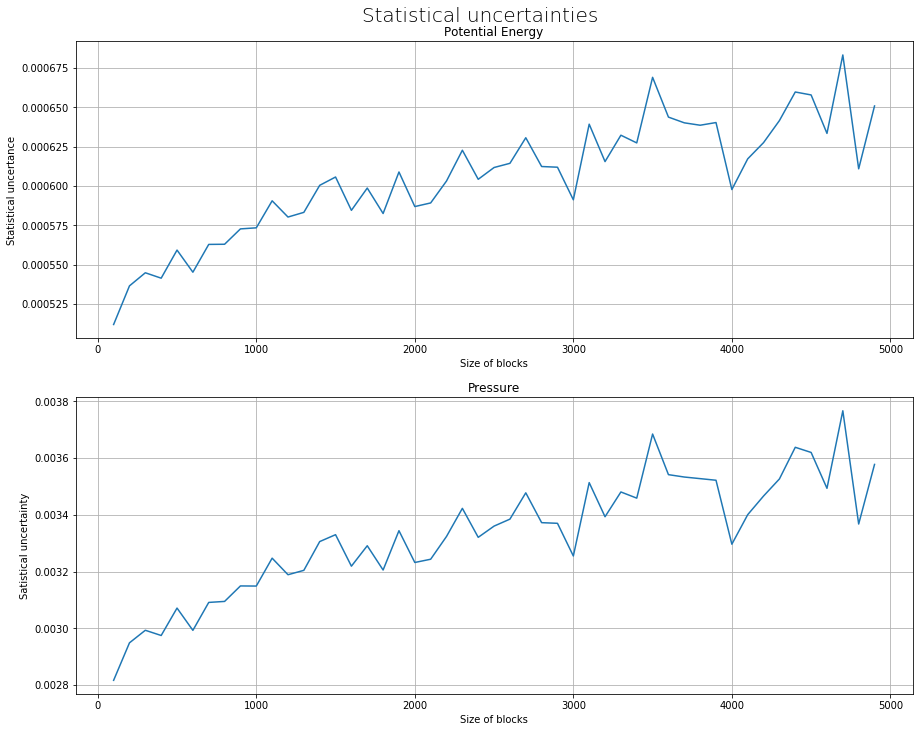

In [13]:
fig = plt.figure(figsize=(15, 12))
fig.suptitle('Statistical uncertainties', y='0.92', size='20', weight='20')
gs = gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
plt.plot(sizeE, sigmaE)
plt.xlabel("Size of blocks")
plt.ylabel("Statistical uncertance")
plt.grid()
plt.title("Potential Energy")

ax2 = fig.add_subplot(gs[1, :])
plt.plot(sizeP,sigmaP)
plt.xlabel("Size of blocks")
plt.ylabel("Satistical uncertainty")
plt.grid()
plt.title("Pressure")

plt.show()

In [16]:
block, epot, sigmaepot = np.loadtxt('./Solid/output.epot.0', usecols=(0,2,3), unpack='true')
block, press, sigmapress= np.loadtxt('./Solid/output.pres.0', usecols=(0,2,3), unpack='true')
r, g, sigmag= np.loadtxt('./Solid/output.gave.0', usecols=(0,1,2), unpack='true')

eps_kb=120 #Argon
sigma=0.34e-9

k=1.380649e-23
eps=eps_kb*k
#SI

epot=epot*eps
sigmaepot=sigmaepot*eps

press=press*eps/(sigma*sigma*sigma)
r=r*sigma

In [17]:
r4, g4, sigmag4= np.loadtxt('./MolDyn_NVE/Solid/output.gave.0', usecols=(0,1,2), unpack='true')
r4=r4*sigma

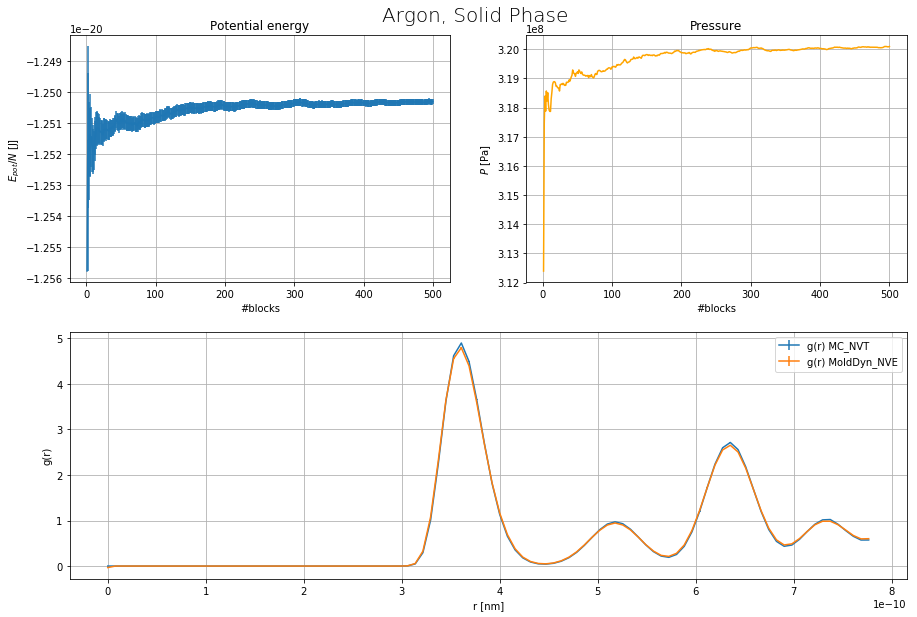

In [18]:
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Argon, Solid Phase', y='0.92', size='20', weight='20')
gs = gridspec.GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
plt.errorbar(block,epot,yerr=sigmaepot)
plt.xlabel('#blocks')
plt.ylabel('$E_{pot}/N$ [J]')
plt.title ("Potential energy")
plt.grid(True)

ax2 = fig.add_subplot(gs[0, 1])
plt.errorbar(block,press,yerr=sigmapress, color="orange")
plt.xlabel('#blocks')
plt.ylabel('$P$ [Pa]')
plt.title ("Pressure")
plt.grid(True)


ax5 = fig.add_subplot(gs[1, :])
plt.errorbar(r,g,yerr=sigmag, label="g(r) MC_NVT")
plt.errorbar(r4,g4,yerr=sigmag4, label="g(r) MoldDyn_NVE")
plt.xlabel('r [nm]')
plt.ylabel('g(r)')
ax5.legend()
plt.grid(True)

plt.show()

## Fase gassosa

Fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

Si è scelto un passo elevato per provare ad abbassare l'acceptance rate; con $delta=0.9$ la percentuale di nuove proposte accettate raggiunge quasi l'80%.

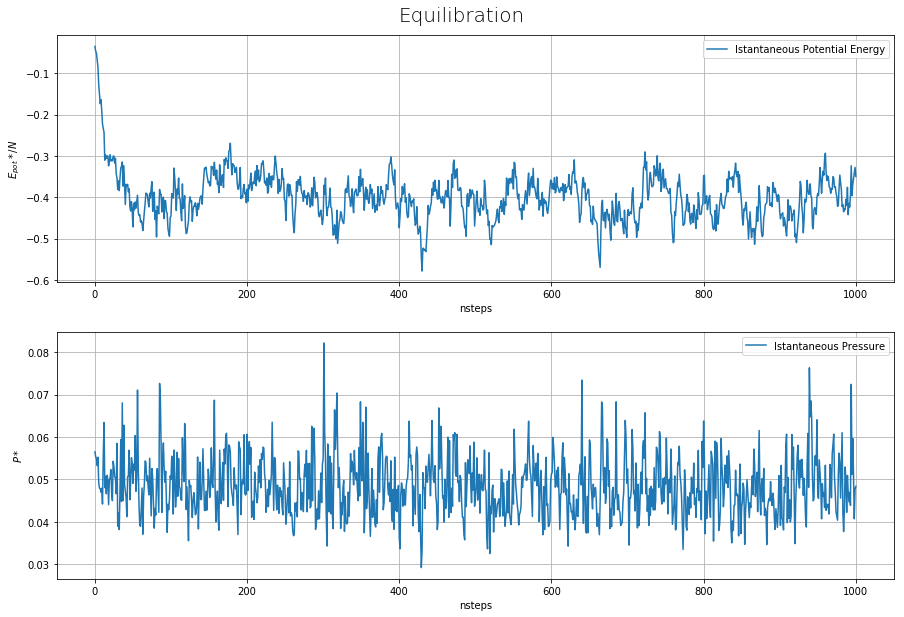

In [11]:
Epot = np.loadtxt('./Gas/Equi/output.epot.dat', usecols=(0), unpack='true')
pres = np.loadtxt('./Gas/Equi/output.pres.dat', usecols=(0), unpack='true')

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Equilibration', y='0.92', size='20', weight='20')
gs = gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
plt.plot(Epot, label="Istantaneous Potential Energy" )
plt.xlabel("nsteps")
plt.ylabel("$E_{pot}*/N$")
plt.grid(True)
plt.legend()

ax2 = fig.add_subplot(gs[1, :])
plt.plot(pres, label="Istantaneous Pressure" )
plt.xlabel("nsteps")
plt.ylabel("$P*$")
plt.grid(True)
plt.legend()
plt.show()

Il sistema è equilibrato dopo circa 200 anche se le grandezze studiate continuano a fluttuare anche per passi elevati su ampiezze relative del 20%.

In [65]:
Epot = np.loadtxt('./Gas/output.epot.dat', usecols=(0), unpack='true')
pres = np.loadtxt('./Gas/output.pres.dat', usecols=(0), unpack='true')

autoE=autocorr(Epot)
autoP=autocorr(pres)

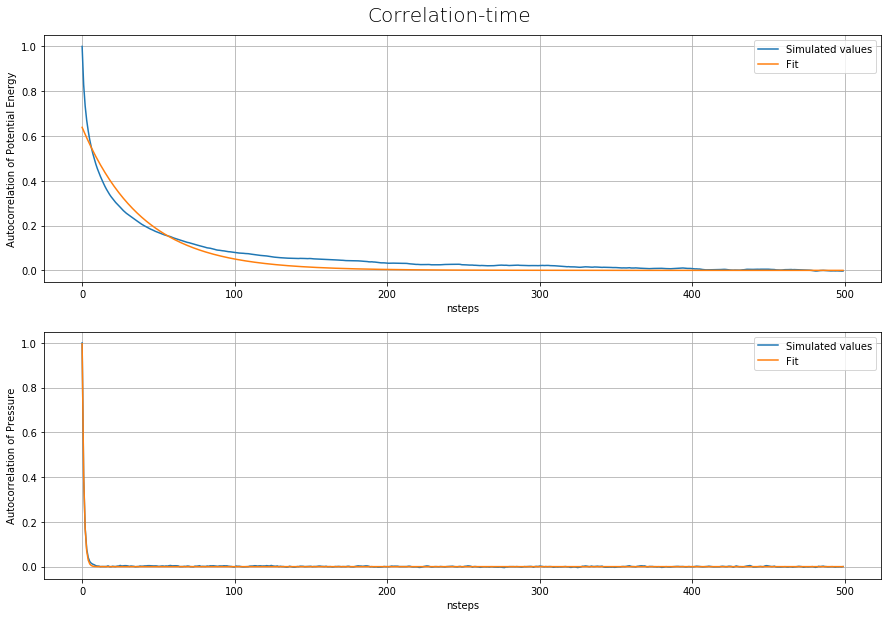

In [66]:
x=np.arange(0, 500, 1)
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Correlation-time', y='0.92', size='20', weight='20')
gs = gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
p_opt, p_cov = opt.curve_fit(f, x, autoE)
y_fit = f(x,p_opt[0], p_opt[1])
plt.plot(x, autoE, label="Simulated values")
plt.plot(x,y_fit, label="Fit") # plotting fitted function
plt.xlabel("nsteps")
plt.ylabel("Autocorrelation of Potential Energy")
plt.grid()
plt.legend()


ax2 = fig.add_subplot(gs[1, :])
p_opt, p_cov = opt.curve_fit(f, x, autoP)
y_fit = f(x,p_opt[0], p_opt[1])
plt.plot(x, autoP, label="Simulated values")
plt.plot(x,y_fit, label="Fit") # plotting fitted function
plt.xlabel("nsteps")
plt.ylabel("Autocorrelation of Pressure")
plt.grid()
plt.legend()

plt.show()



Si nota come la pressione della fase gassosa presenti tempi di autocorrelazione bassissimi: il sistema gassoso è particolarmente disordinato, quindi la pressione a un dato tempo dipende solamente dalle condizioni in un intrevallo di tempo temporale particolarmente ridotto.

In [67]:
sizeE, sigmaE=Statist_Unc(Epot)
sizeP, sigmaP=Statist_Unc(pres)

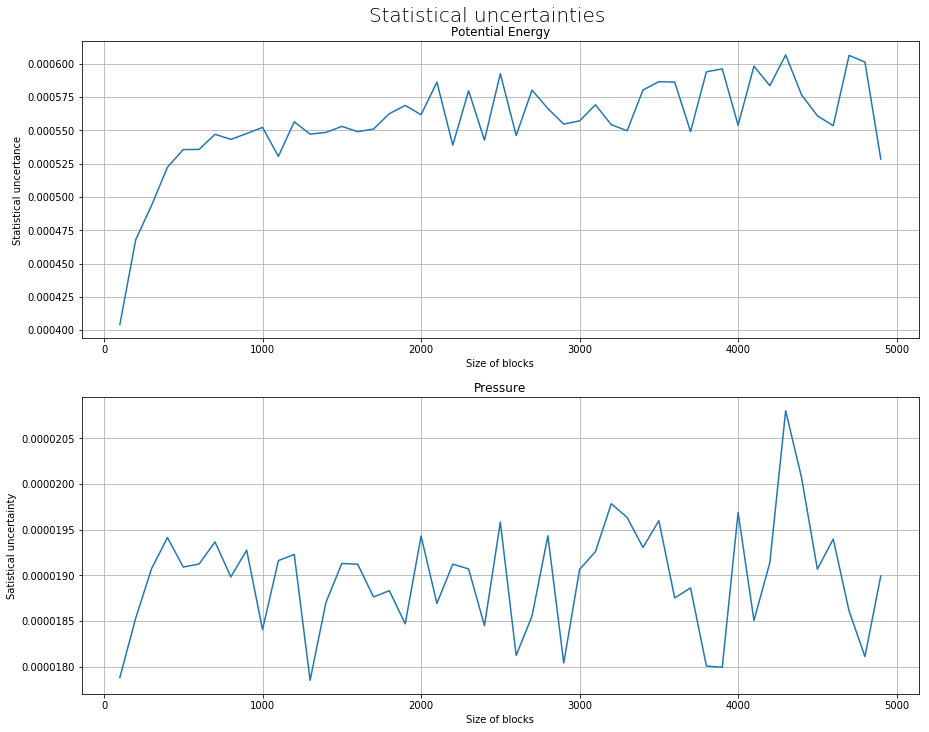

In [68]:
fig = plt.figure(figsize=(15, 12))
fig.suptitle('Statistical uncertainties', y='0.92', size='20', weight='20')
gs = gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
plt.plot(sizeE, sigmaE)
plt.xlabel("Size of blocks")
plt.ylabel("Statistical uncertance")
plt.grid()
plt.title("Potential Energy")

ax2 = fig.add_subplot(gs[1, :])
plt.plot(sizeP,sigmaP)
plt.xlabel("Size of blocks")
plt.ylabel("Satistical uncertainty")
plt.grid()
plt.title("Pressure")

plt.show()

In [19]:
block, epot, sigmaepot = np.loadtxt('./Gas/output.epot.0', usecols=(0,2,3), unpack='true')
block, press, sigmapress= np.loadtxt('./Gas/output.pres.0', usecols=(0,2,3), unpack='true')
r, g, sigmag= np.loadtxt('./Gas/output.gave.0', usecols=(0,1,2), unpack='true')

eps_kb=120 #Argon
sigma=0.34e-9

k=1.380649e-23
eps=eps_kb*k
#SI

epot=epot*eps
sigmaepot=sigmaepot*eps

press=press*eps/(sigma*sigma*sigma)
r=r*sigma

In [20]:
r4, g4, sigmag4= np.loadtxt('./MolDyn_NVE/Gas/output.gave.0', usecols=(0,1,2), unpack='true')
r4=r4*sigma

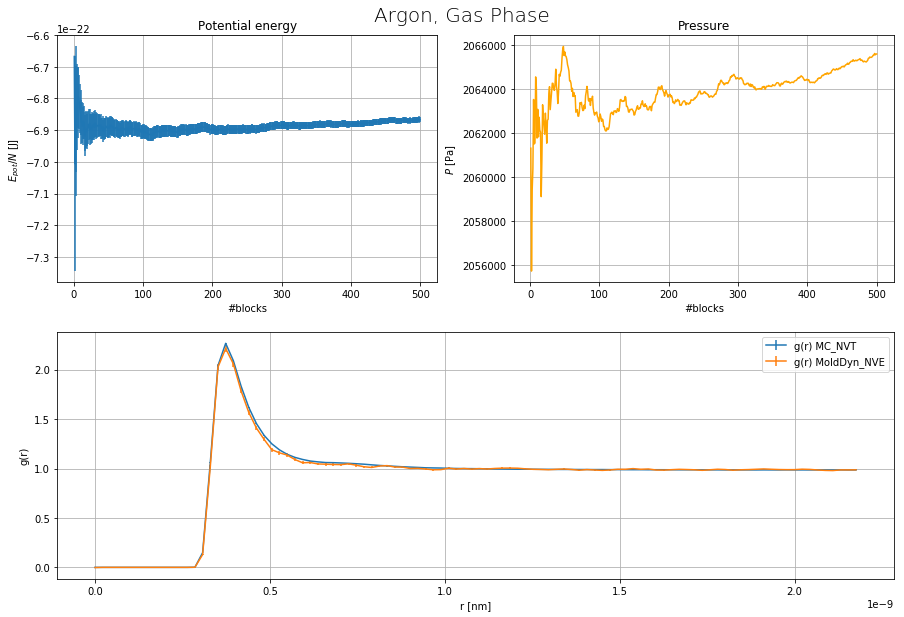

In [21]:
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Argon, Gas Phase', y='0.92', size='20', weight='20')
gs = gridspec.GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
plt.errorbar(block,epot,yerr=sigmaepot)
plt.xlabel('#blocks')
plt.ylabel('$E_{pot}/N$ [J]')
plt.title ("Potential energy")
plt.grid(True)

ax2 = fig.add_subplot(gs[0, 1])
plt.errorbar(block,press,yerr=sigmapress, color="orange")
plt.xlabel('#blocks')
plt.ylabel('$P$ [Pa]')
plt.title ("Pressure")
plt.grid(True)


ax5 = fig.add_subplot(gs[1, :])
plt.errorbar(r,g,yerr=sigmag, label="g(r) MC_NVT")
plt.errorbar(r4,g4,yerr=sigmag4, label="g(r) MoldDyn_NVE")
plt.xlabel('r [nm]')
plt.ylabel('g(r)')
ax5.legend()
plt.grid(True)

plt.show()